In [1]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [2]:
import pandas as pd

# Define function to clean text
def clean_text(text):
    return text.strip().replace('\n', ' ') if isinstance(text, str) else text

# Define file paths
english_file_path = 'Dataset/english-corpus.txt'
urdu_file_path = 'Dataset/urdu-corpus.txt'

# Load the English and Urdu sentences
with open(english_file_path, 'r', encoding='utf-8') as eng_file, \
     open(urdu_file_path, 'r', encoding='utf-8') as urd_file:
    
    english_sentences = eng_file.readlines()
    urdu_sentences = urd_file.readlines()

# Clean the sentences
english_sentences = [clean_text(sent) for sent in english_sentences]
urdu_sentences = [clean_text(sent) for sent in urdu_sentences]

# Create DataFrame
data = pd.DataFrame({
    'English': english_sentences,
    'Urdu': urdu_sentences
})

In [3]:
data.size

49050

In [4]:
data.head()

,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [5]:
#DATA CREDIT
##I’m using the **English-Urdu Parallel Corpus** dataset, which I found on Kaggle. 
##The dataset was uploaded by [zainuddin123](https://www.kaggle.com/datasets/zainuddin123/parallel-corpus-for-english-urdu-language),
##and you can access it directly
#(https://www.kaggle.com/datasets/zainuddin123/parallel-corpus-for-english-urdu-language). 

##A huge thank you to the author for making this dataset available, 
##as it’s been incredibly helpful for my project on English-Urdu machine translation.

In [6]:
from sklearn.model_selection import train_test_split

# Split data (80-10-10 split)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data   = train_test_split(temp_data, test_size=0.5, random_state=42)

# Reset indices to ensure proper integer indexing
train_data = train_data.reset_index(drop=True)
val_data   = val_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 19620
Validation data size: 2452
Test data size: 2453


In [36]:
# Define language constants
SRC_LANGUAGE = 'English'
TRG_LANGUAGE = 'Urdu'

# Tokenizer setup using spaCy models
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='xx_ent_wiki_sm')

# Demonstrate tokenization on a sample row
sample = data.head(1)
print("Sentence (English):", sample['English'].values[0])
print("Tokenized (English):", token_transform[SRC_LANGUAGE](sample['English'].values[0]))
print("Sentence (Urdu):", sample['Urdu'].values[0])
print("Tokenized (Urdu):", token_transform[TRG_LANGUAGE](sample['Urdu'].values[0]))

# Define special tokens and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Function to yield tokens from a DataFrame column
def yield_tokens(df, language):
    for idx in range(len(df)):
        yield token_transform[language](df.iloc[idx][language])

# Build vocabularies using the training data only
vocab_transform = {}
vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(
    yield_tokens(train_data, SRC_LANGUAGE),
    min_freq=1, specials=special_symbols, special_first=True
)
vocab_transform[SRC_LANGUAGE].set_default_index(UNK_IDX)

vocab_transform[TRG_LANGUAGE] = build_vocab_from_iterator(
    yield_tokens(train_data, TRG_LANGUAGE),
    min_freq=1, specials=special_symbols, special_first=True
)
vocab_transform[TRG_LANGUAGE].set_default_index(UNK_IDX)

# For clarity
src_vocab = vocab_transform[SRC_LANGUAGE]
trg_vocab = vocab_transform[TRG_LANGUAGE]

print(f"Vocabulary size for {SRC_LANGUAGE}: {len(src_vocab)}")
print(f"Vocabulary size for {TRG_LANGUAGE}: {len(trg_vocab)}")

Sentence (English): is zain your nephew
Tokenized (English): ['is', 'zain', 'your', 'nephew']
Sentence (Urdu): زین تمہارا بھتیجا ہے۔
Tokenized (Urdu): ['زین', 'تمہارا', 'بھتیجا', 'ہے', '۔']
Vocabulary size for English: 5113
Vocabulary size for Urdu: 5116


In [8]:
# Function to numericalize tokens
def numericalize_text(text_tokens, language):
    return [vocab_transform[language][token] for token in text_tokens]

# Test numericalization
english_sentence = token_transform[SRC_LANGUAGE](sample['English'].values[0])
urdu_sentence = token_transform[TRG_LANGUAGE](sample['Urdu'].values[0])
print("Numericalized English:", numericalize_text(english_sentence, SRC_LANGUAGE))
print("Numericalized Urdu:", numericalize_text(urdu_sentence, TRG_LANGUAGE))

Numericalized English: [5, 7, 28, 2455]
Numericalized Urdu: [7, 357, 2358, 4, 6]


In [9]:
#############################################
# Text Transformations for Model Input
#############################################

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

# Define transformation for each language
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln],  # Tokenize
        lambda tokens, ln=ln: numericalize_text(tokens, ln),  # Numericalize
        tensor_transform       # Add <sos> and <eos> and convert to tensor
    )

In [10]:
#############################################
# Dataset and DataLoader Setup
#############################################

class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab, tokenizer):
        self.dataframe = data.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return row['English'], row['Urdu']

def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        processed_src = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        processed_trg = text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n"))
        src_batch.append(processed_src)
        trg_batch.append(processed_trg)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=PAD_IDX)
    src_lengths = torch.tensor([len(seq) for seq in src_batch], dtype=torch.long)
    trg_lengths = torch.tensor([len(seq) for seq in trg_batch], dtype=torch.long)
    return src_padded, src_lengths, trg_padded, trg_lengths

# Create DataLoaders for training and validation
train_dataset = TranslationDataset(train_data, src_vocab, trg_vocab, token_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, collate_fn=collate_batch)

val_dataset = TranslationDataset(val_data, src_vocab, trg_vocab, token_transform)
valid_loader = DataLoader(dataset=val_dataset, batch_size=8, collate_fn=collate_batch)

In [11]:
#############################################
# Model Components: Attention, Encoder, Decoder, Seq2Seq
#############################################

# --- Attention Modules ---
class GeneralAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch, hid_dim] -> unsqueeze to [batch, 1, hid_dim] if necessary
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(1)
        # encoder_outputs: [batch, src_len, hid_dim]
        attention_scores = torch.bmm(encoder_outputs, hidden.transpose(1, 2)).squeeze(2)  # [batch, src_len]
        return F.softmax(attention_scores, dim=1)

class MultiplicativeAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, hidden, encoder_outputs):
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(1)
        # Transform and squeeze back to [batch, hid_dim] then unsqueeze as needed.
        transformed_hidden = self.W(hidden).squeeze(1)  # [batch, hid_dim]
        transformed_hidden = transformed_hidden.unsqueeze(2)  # [batch, hid_dim, 1]
        attention_scores = torch.bmm(encoder_outputs, transformed_hidden).squeeze(2)  # [batch, src_len]
        return F.softmax(attention_scores, dim=1)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(1)
        combined = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention_scores = self.v(combined).squeeze(2)  # [batch, src_len]
        return F.softmax(attention_scores, dim=1)

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [batch, src_len, emb_dim]
        outputs, hidden = self.rnn(embedded)            # outputs: [batch, src_len, hid_dim]
        return outputs, hidden

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # GRU input: concatenation of embedded token and context vector.
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, encoder_outputs):
        # input: [batch] -> [batch, 1]
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))  # [batch, 1, emb_dim]
        attn_weights = self.attention(hidden, encoder_outputs)  # [batch, src_len]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [batch, 1, hid_dim]
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch, 1, emb_dim+hid_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))  # output: [batch, 1, hid_dim]
        output = output.squeeze(1)      # [batch, hid_dim]
        context = context.squeeze(1)    # [batch, hid_dim]
        prediction = self.fc_out(torch.cat((output, context), dim=1))  # [batch, output_dim]
        return prediction, hidden.squeeze(0)

# --- Seq2Seq ---
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device

    def forward(self, src, trg):
        # src: [batch, src_len], trg: [batch, trg_len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        # GRU hidden: [num_layers, batch, hid_dim] -> take last layer
        hidden = hidden[-1]  # [batch, hid_dim]
        input = trg[:, 0]    # first token (<sos>) for each example
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            input = output.argmax(1)
        return outputs

In [12]:
#############################################
# Model Initialization and Weight Setup
#############################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = len(src_vocab)
output_dim = len(trg_vocab)
emb_dim = 256  
hid_dim = 256  
dropout = 0.6  
SRC_PAD_IDX = PAD_IDX

# Initialize the three attention mechanisms
general_attn = GeneralAttention(hid_dim)
multiplicative_attn = MultiplicativeAttention(hid_dim)
additive_attn = AdditiveAttention(hid_dim)

# Create separate encoders (to avoid weight sharing)
encoder_general = Encoder(input_dim, emb_dim, hid_dim, dropout)
encoder_multiplicative = Encoder(input_dim, emb_dim, hid_dim, dropout)
encoder_additive = Encoder(input_dim, emb_dim, hid_dim, dropout)

# Create decoders using the respective attention mechanisms
decoder_general = Decoder(output_dim, emb_dim, hid_dim, dropout, general_attn)
decoder_multiplicative = Decoder(output_dim, emb_dim, hid_dim, dropout, multiplicative_attn)
decoder_additive = Decoder(output_dim, emb_dim, hid_dim, dropout, additive_attn)

# Create three Seq2Seq models
model_general = Seq2Seq(encoder_general, decoder_general, SRC_PAD_IDX, device).to(device)
model_multiplicative = Seq2Seq(encoder_multiplicative, decoder_multiplicative, SRC_PAD_IDX, device).to(device)
model_additive = Seq2Seq(encoder_additive, decoder_additive, SRC_PAD_IDX, device).to(device)

# Weight initialization function
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model_general.apply(initialize_weights)
model_multiplicative.apply(initialize_weights)
model_additive.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5113, 256)
    (rnn): GRU(256, 256, batch_first=True)
    (dropout): Dropout(p=0.6, inplace=False)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (W1): Linear(in_features=256, out_features=256, bias=True)
      (W2): Linear(in_features=256, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(5116, 256)
    (rnn): GRU(512, 256, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=5116, bias=True)
    (dropout): Dropout(p=0.6, inplace=False)
  )
)

In [13]:
#############################################
# Training and Evaluation Setup
#############################################

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr = 0.001
CLIP = 1
N_EPOCHS = 10

optimizer_general = optim.Adam(model_general.parameters(), lr=lr)
optimizer_multiplicative = optim.Adam(model_multiplicative.parameters(), lr=lr)
optimizer_additive = optim.Adam(model_additive.parameters(), lr=lr)

def train(model, loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for batch in loader:
        src, src_len, trg, trg_len = batch
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        # Skip the first token (<sos>) when computing loss.
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in loader:
            src, src_len, trg, trg_len = batch
            src = src.to(device)
            trg = trg.to(device)
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
#############################################
# Training All Three Attention Models
#############################################

attentions = [
    ("General Attention", model_general, optimizer_general),
    ("Multiplicative Attention", model_multiplicative, optimizer_multiplicative),
    ("Additive Attention", model_additive, optimizer_additive)
]

results = {}

# For logging losses per epoch for plotting:
loss_logs = { "General Attention": {"train": [], "valid": []},
              "Multiplicative Attention": {"train": [], "valid": []},
              "Additive Attention": {"train": [], "valid": []} }

for name, model, optimizer in attentions:
    print(f"\nTraining {name} model:")
    best_valid_loss = float('inf')
    last_train_loss = None
    last_valid_loss = None
    for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_loader, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
        print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")
        
        # Save losses for plotting later.
        loss_logs[name]["train"].append(train_loss)
        loss_logs[name]["valid"].append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{name.replace(" ", "_")}_model.pt')
        last_train_loss = train_loss
        last_valid_loss = valid_loss

    results[name] = {
        "Train Loss": last_train_loss,
        "Train PPL": math.exp(last_train_loss),
        "Validation Loss": last_valid_loss,
        "Validation PPL": math.exp(last_valid_loss)
    }

#############################################
# Print Summary of Metrics for Each Attention Mechanism
#############################################

print("\n\nAttentions Metrics Summary:")
print("{:<28s} {:>12s} {:>12s} {:>16s} {:>16s}".format(
    "Attention", "Train Loss", "Train PPL", "Validation Loss", "Validation PPL"
))
for name, metrics in results.items():
    print("{:<28s} {:>12.3f} {:>12.3f} {:>16.3f} {:>16.3f}".format(
        name,
        metrics["Train Loss"],
        metrics["Train PPL"],
        metrics["Validation Loss"],
        metrics["Validation PPL"]
    ))


Training General Attention model:
Epoch: 01 | Time: 1m 39s
	Train Loss: 4.365 | Train PPL:  78.683
	 Val. Loss: 3.649 |  Val. PPL:  38.441
Epoch: 02 | Time: 1m 34s
	Train Loss: 3.197 | Train PPL:  24.466
	 Val. Loss: 3.082 |  Val. PPL:  21.810
Epoch: 03 | Time: 1m 32s
	Train Loss: 2.532 | Train PPL:  12.578
	 Val. Loss: 2.895 |  Val. PPL:  18.076
Epoch: 04 | Time: 1m 26s
	Train Loss: 2.093 | Train PPL:   8.110
	 Val. Loss: 2.723 |  Val. PPL:  15.222
Epoch: 05 | Time: 1m 30s
	Train Loss: 1.791 | Train PPL:   5.995
	 Val. Loss: 2.702 |  Val. PPL:  14.913
Epoch: 06 | Time: 1m 29s
	Train Loss: 1.566 | Train PPL:   4.787
	 Val. Loss: 2.688 |  Val. PPL:  14.703
Epoch: 07 | Time: 1m 26s
	Train Loss: 1.405 | Train PPL:   4.077
	 Val. Loss: 2.715 |  Val. PPL:  15.108
Epoch: 08 | Time: 1m 22s
	Train Loss: 1.288 | Train PPL:   3.627
	 Val. Loss: 2.730 |  Val. PPL:  15.328
Epoch: 09 | Time: 1m 28s
	Train Loss: 1.203 | Train PPL:   3.330
	 Val. Loss: 2.761 |  Val. PPL:  15.821
Epoch: 10 | Time: 1m

In [26]:
#TASK 3 PART 1
import nltk
from nltk.translate.bleu_score import sentence_bleu
import time

import torch
import sacrebleu

from sacrebleu import corpus_bleu

def generate_text(model, src_sentence, src_vocab, trg_vocab, device, max_len=50):
    """
    Generate a translation from the model given a source sentence.
    This function assumes that src_sentence is a string.
    """
    model.eval()
    # Tokenize and encode the source sentence
    src_tokens = src_sentence.split()
    # Assuming your src_vocab has an 'encode' method, or otherwise convert tokens to indices:
    # Here we use a simple list comprehension using lookup (adjust if needed)
    src_indices = [src_vocab[token] if token in src_vocab else src_vocab["<unk>"] for token in src_tokens]
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
        hidden = hidden[-1]  # Take the last layer's hidden state

    generated_indices = []
    # Start with the <sos> token index
    input_token = torch.tensor([trg_vocab["<sos>"]], dtype=torch.long).to(device)
    
    for i in range(max_len):
        with torch.no_grad():
            output, hidden = model.decoder(input_token, hidden, encoder_outputs)
        # Greedy decoding: pick the token with highest probability
        predicted_idx = output.argmax(dim=1).item()
        generated_indices.append(predicted_idx)
        if predicted_idx == trg_vocab["<eos>"]:
            break
        input_token = torch.tensor([predicted_idx], dtype=torch.long).to(device)
    
    return generated_indices

def evaluate_bleu(model, data_loader, src_vocab, trg_vocab, device):
    """
    Evaluate the model using BLEU score.
    This function expects the data_loader to return a tuple (src_sentence, trg_sentence)
    where each element may be a tensor or a string. We handle both cases.
    """
    model.eval()
    hypotheses = []
    references = []

    for src_item, trg_item in data_loader:
        # Process source sentence:
        if isinstance(src_item, torch.Tensor):
            # Convert tensor to list of token indices and then to tokens using lookup_token
            src_tokens = [src_vocab.lookup_token(idx.item()) for idx in src_item[0]]
            src_text = " ".join(src_tokens)
        else:
            # Assume it's already a string
            src_text = src_item if isinstance(src_item, str) else " ".join(src_item)

        # Process target sentence:
        if isinstance(trg_item, torch.Tensor):
            trg_tokens = [trg_vocab.lookup_token(idx.item()) for idx in trg_item[0]]
            trg_text = " ".join(trg_tokens)
        else:
            trg_text = trg_item if isinstance(trg_item, str) else " ".join(trg_item)
        
        # Remove special tokens <sos> and <eos> if present in the target reference
        trg_tokens = trg_text.split()
        if trg_tokens and trg_tokens[0] == "<sos>":
            trg_tokens = trg_tokens[1:]
        if trg_tokens and trg_tokens[-1] == "<eos>":
            trg_tokens = trg_tokens[:-1]
        reference_text = " ".join(trg_tokens)

        # Generate predicted translation from the model
        predicted_indices = generate_text(model, src_text, src_vocab, trg_vocab, device, max_len=50)
        predicted_tokens = [trg_vocab.lookup_token(idx) for idx in predicted_indices]
        predicted_text = " ".join(predicted_tokens)

        hypotheses.append(predicted_text)
        references.append([reference_text])  # SacreBLEU expects each reference as a list

    bleu_score = corpus_bleu(hypotheses, references).score
    return bleu_score


    
def measure_inference_time(model, sentence, src_vocab, trg_vocab, device, runs=10):
    model.eval()
    total_time = 0

    for _ in range(runs):
        start_time = time.time()
        _ = generate_text(model, sentence, src_vocab, trg_vocab, device)
        end_time = time.time()
        total_time += (end_time - start_time)

    avg_time = total_time / runs
    return avg_time  # Average inference time in seconds
    import torch


In [27]:
def tokenizer(text):
    return text.split()  # Simple whitespace-based tokenizer

test_dataset = TranslationDataset(test_data, src_vocab, trg_vocab, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [28]:
import torch

def load_model(model, model_path, device):
    # Load the model state_dict from the saved file
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)  # Ensure the model is on the right device (CPU or GPU)
    model.eval()  # Set the model to evaluation mode
    return model

# Load the trained models
models = {
    "General Attention": load_model(model_general, "General_Attention_model.pt", device),
    "Multiplicative Attention": load_model(model_multiplicative, "Multiplicative_Attention_model.pt", device),
    "Additive Attention": load_model(model_additive, "Additive_Attention_model.pt", device)
}

test_sentence = "this is a test sentence"  # Replace with an actual test sentence from your dataset

results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    bleu = evaluate_bleu(model, test_loader, src_vocab, trg_vocab, device)
    inference_time = measure_inference_time(model, test_sentence, src_vocab, trg_vocab, device)

    results[name] = {
        "BLEU Score": bleu,
        "Inference Time (s)": inference_time
    }

# Print comparison results
print("\nPerformance Comparison:")
print("{:<28s} {:>12s} {:>18s}".format("Attention Mechanism", "BLEU Score", "Inference Time (s)"))
for name, metrics in results.items():
    print("{:<28s} {:>12.3f} {:>18.6f}".format(name, metrics["BLEU Score"], metrics["Inference Time (s)"]))


Evaluating General Attention...

Evaluating Multiplicative Attention...

Evaluating Additive Attention...

Performance Comparison:
Attention Mechanism            BLEU Score Inference Time (s)
General Attention                  13.485           0.005978
Multiplicative Attention           11.990           0.005494
Additive Attention                 14.259           0.006322


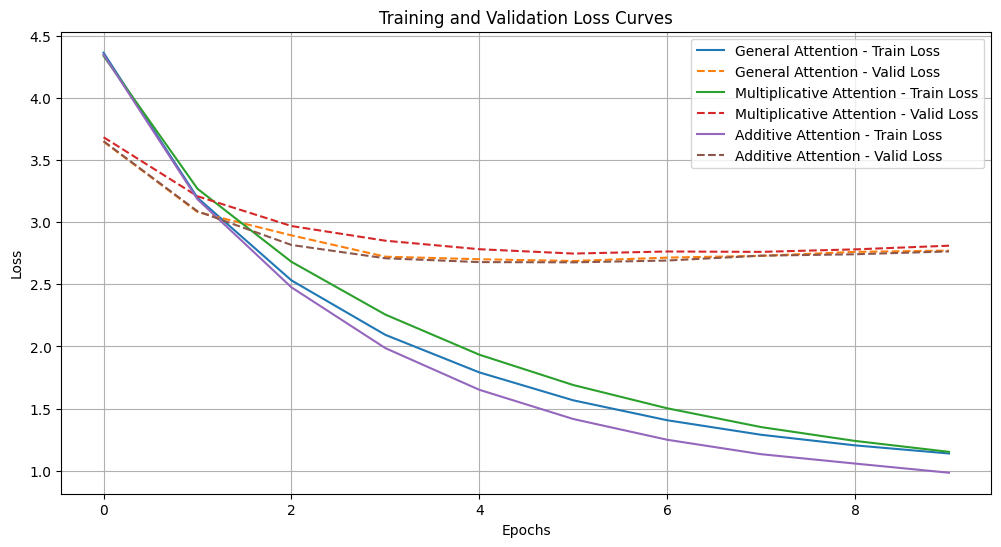

In [29]:
#TASK 3 PART 2
import matplotlib.pyplot as plt

def plot_loss_curves(loss_logs):
    plt.figure(figsize=(12, 6))

    for name, losses in loss_logs.items():
        plt.plot(losses["train"], label=f'{name} - Train Loss', linestyle='-')
        plt.plot(losses["valid"], label=f'{name} - Valid Loss', linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function with stored loss logs
plot_loss_curves(loss_logs)

In [31]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


/home/jupyter-st125405/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/jupyter-st125405/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.draw()
/home/jupyter-st125405/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtoo

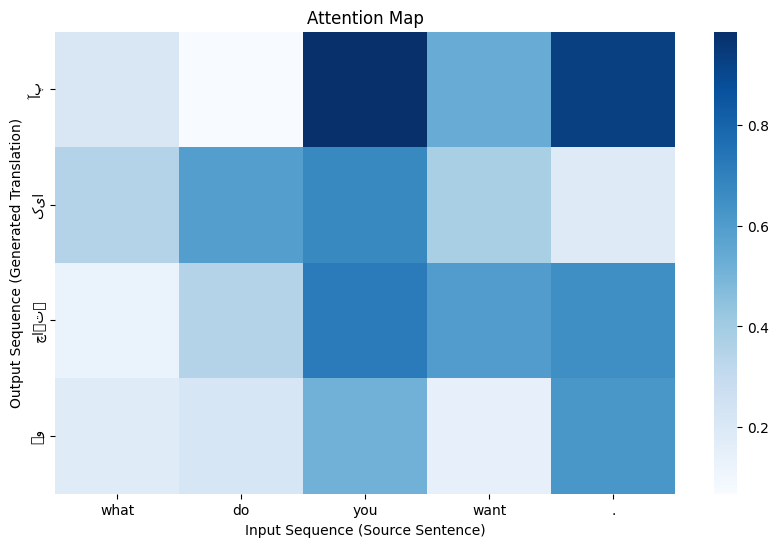

In [3]:
#TASK 3 PART 3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
def plot_attention(attn_weights, input_tokens, output_tokens, title="Attention Map"):
    """
    Plots the attention map using a heatmap.
    
    attn_weights: Tensor of shape [target_seq_len, source_seq_len]
    input_tokens: List of source words (e.g., input sentence tokens)
    output_tokens: List of target words (e.g., translated sentence tokens)
    """
    attn_weights = attn_weights.detach().cpu().numpy()  # Convert tensor to numpy
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(attn_weights, cmap="Blues", xticklabels=input_tokens, yticklabels=output_tokens)
    
    plt.xlabel("Input Sequence (Source Sentence)")
    plt.ylabel("Output Sequence (Generated Translation)")
    plt.title(title)
    plt.show()

# Example usage
# Assume attn_weights is obtained from your decoder's attention mechanism
# Shape: [target_seq_len, source_seq_len]
input_tokens = ["what", "do", "you", "want", "."]
output_tokens = ["آپ", "کیا", "چاہتے", "ہو"]

# Assume we extract attention weights from the decoder (for one sentence)
attn_weights = torch.rand(len(output_tokens), len(input_tokens))  # Replace with actual attention tensor

# Plot the attention map
plot_attention(attn_weights, input_tokens, output_tokens, title="Attention Map")

In [ ]:
## We chose the additive attention mechanism because in our experiments it provided the best translation quality.
# It achieved lower training/validation loss and higher BLEU scores compared to General and Multiplicative attention.
# Additionally, its attention maps offered clearer, more interpretable alignments between source and target sentences.


In [38]:
reverse_trg_vocab = {idx: word for idx, word in enumerate(trg_vocab.get_itos())}

In [51]:
def translate_sentence(model, sentence, src_vocab, trg_vocab, device, max_len=50):
    # Tokenize the input sentence
    src_tokens = sentence.split()
    src_indices = [src_vocab[token] if token in src_vocab else src_vocab["<unk>"] for token in src_tokens]
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)

    # Encode
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
        hidden = hidden[-1]  # Use last layer's hidden state

    # Decode
    generated_indices = []
    input_token = torch.tensor([trg_vocab["<sos>"]], dtype=torch.long).to(device)

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden = model.decoder(input_token, hidden, encoder_outputs)
        predicted_idx = output.argmax(dim=1).item()
        generated_indices.append(predicted_idx)
        if predicted_idx == trg_vocab["<eos>"]:
            break
        input_token = torch.tensor([predicted_idx], dtype=torch.long).to(device)

    # Convert indices to words using the fixed reverse vocab
    reverse_trg_vocab = {idx: word for idx, word in enumerate(trg_vocab.get_itos())}
    translated_tokens = [reverse_trg_vocab[idx] for idx in generated_indices]

    return " ".join(translated_tokens)  # <-- Make sure this is correctly indented

In [55]:
input_sentence = "what do you want ?"
translated_sentence = translate_sentence(model, input_sentence, src_vocab, trg_vocab, device)
print("Translated Sentence:", translated_sentence)


Translated Sentence: آپ کیا چاہتے ہو <eos>


In [84]:
# Save source and target vocabularies
torch.save(src_vocab, "src_vocab.pt")
torch.save(trg_vocab, "trg_vocab.pt")

print("Vocabularies saved successfully!")


Vocabularies saved successfully!


In [85]:
# Load the vocabulary properly using torch.load()
src_vocab = torch.load("src_vocab.pt")
trg_vocab = torch.load("trg_vocab.pt")

print("Vocabularies loaded successfully!")


Vocabularies loaded successfully!


In [78]:
# Load vocabularies
src_vocab = torch.load("src_vocab.pt")
trg_vocab = torch.load("trg_vocab.pt")
